In [1]:
from scipy.io import loadmat
import numpy as np
from numpy import *
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pickle
from control import lqr, ss
from control.matlab import lsim
import random
import itertools
from tqdm import tqdm
import os

**The Tabular value-fucntion methods on the cart and pole system**

Consider the cart-and-pole system here depicted:
<div>
<img src="https://drive.google.com/uc?export=view&id=1Yu5zZ57OEEYZ678yWLaU7h-Wq3M9vV9E" width="200">
</div>
whose dynamics follows the following equations:

\begin{align}
  \ddot{\theta}&=\frac{g \sin(\theta)\,+\,\cos(\theta) \left[ \frac{-F\,-\,m_p\,l\,\dot{\theta}^2 \sin \left(\theta\right)}{m_c\,+\,m_p}\right]-\frac{\mu_p\dot{\theta}}{m_p\,l}}{l\,\left[\frac{4}{3}-\frac{m_p\,cos^2\left(\theta\right)}{m_c\,+\,m_p}\right]}
\end{align}
>>>>>>>>>>>>>>>>>>>>>>>>$(*)$

\begin{align}
  \ddot{p}_c&=\frac{F\,+\,m_p\,l\,\left[\dot{\theta}^2\,\sin\left(\theta\right)\,-\,\ddot{\theta}\,\cos(\theta)\right]}{m_c\,+\,m_p}
\end{align}

where $g = 9.8\,\text{m/sec}$ is the gravitational acceleration, $m_c = 1\,\text{kg}$ is the cart mass, $m_p = 0.1\,\text{kg}$ is the pole mass, $l = 0.5\,\text{m}$ is the half-pole length, $\mu_p = 0.000002$ is the pole on cart friction coefficient.

In [2]:
lowerBounds = [
    deg2rad(-10),
    -1,
    -1,
    -1
]
upperBounds = [- i for i in lowerBounds]
max_steps= 1000

def get_random_initial_state():
    return np.array([np.deg2rad(random.uniform(-1,1)), random.uniform(-1,1), random.uniform(-1,1)/10, random.uniform(-1,1)]) # start out of equilibrium

In [3]:
numberOfBins = [
    10,
    4,
    4,
    4
]

action_size = 2 # left or right

In [4]:
class StateDiscretizer:
    def __init__(self, numberOfBins):
        self.poleAngleBin = np.linspace(lowerBounds[0],upperBounds[0],numberOfBins[0])
        self.poleAngleVelocityBin = np.linspace(lowerBounds[1],upperBounds[1],numberOfBins[1])
        self.cartPositionBin = np.linspace(lowerBounds[2],upperBounds[2],numberOfBins[2])
        self.cartVelocityBin = np.linspace(lowerBounds[3],upperBounds[3],numberOfBins[3])
        self.numberOfBins = numberOfBins


    def discretize_state(self, state):
        angle    =      state[0]
        angularVelocity=state[1]
        position =      state[2]
        velocity =      state[3]

        indexAngle=np.maximum(np.digitize(angle,self.poleAngleBin)-1,0)
        indexAngularVelocity=np.maximum(np.digitize(angularVelocity,self.poleAngleVelocityBin)-1,0)
        indexPosition=np.maximum(np.digitize(position,self.cartPositionBin)-1,0)
        indexVelocity=np.maximum(np.digitize(velocity,self.cartVelocityBin)-1,0)

        return tuple([indexAngle,indexAngularVelocity,indexPosition,indexVelocity])
    
    def is_terminal_state(self, dstate):
        if dstate[0] == 0 or dstate[0] == self.numberOfBins[0]-1:
            return True
        if dstate[2] == 0 or dstate[2] == self.numberOfBins[2]-1:
            return True
        return False

discretizer = StateDiscretizer(numberOfBins)

In [5]:
def cart_and_pole_odeint(x, t, F):
    dxdt = np.zeros_like(x)

    dxdt[0] = x[1] #tetap
    dxdt[1] = (g*sin(x[0])+ cos(x[0])*((-F-m*l*(x[1]**2)*sin(x[0]))/(mc+m))-((miup*x[1])/(m*l))) / (l*((4/3)-((m*(cos(x[0])**2))/(mc+m))))    #teta2p
    dxdt[2] = x[3] #xp
    dxdt[3] = (F+m*l*((x[1]**2)*sin(x[0])-dxdt[1]*cos(x[0])))/(mc+m) #x2p
    return dxdt

g = 9.8 # gravitational acceleration
mc = 1  # cart mass [kg]
l = 0.5 # half-pole length [m]
m = 0.1 # pole mass [kg]
miup = 2e-6 # pole friction coefficient

time_step=0.02
t0_odeint=0
t1_odeint = t0_odeint+0.02
t_odeint = np.array([t0_odeint, t1_odeint])


In [6]:
def load_or_init_Weights(file_name, shape):
    if os.path.exists(file_name):
        return np.load(file_name)
    else:
        return np.zeros(shape)

def save_array(qtable, file_name):
    #if os.path.exists(file_name):
    #    os.system(f"mv {file_name} old/`date +\"%Y-%m-%dT%H:%M:%S%z\"`_{file_name}")
    with open(file_name, "wb") as f:
        np.save(f, qtable)

# 1. Given the $X$ set, select centers and standard deviation of RBFs and create a code that given a state $x$ returns $\phi\left(x,\cdot\right)$.

$q_{function}\left(s,a \right) = \theta^T \phi (s,a)$ is the function equivalent of $Q(s, a)$

The parameters an RBF function expects are:
- the state
- the means
- the standard deviation

To determine the RBF means, an approach is to get all the possible combinations of the discretized state into an array and then use these coordinates as centers.
To do so, I will:
1. load the states into an array
2. calculate all possible combinations of states (cartesian product), so that each possible combination of the state will be covered
3. Make this a center for the rbf function

In [7]:
states = [ discretizer.poleAngleBin,
           discretizer.poleAngleVelocityBin, 
           discretizer.cartPositionBin, 
           discretizer.cartVelocityBin]
states = [s.tolist() for s in states]
rbf_means = np.array(list(itertools.product(*states)))

rbf_std = 0.5
# np.average([np.std(s) for s in states])
# rbf_std

rbf_means.shape

(640, 4)

The RBF function will compute the following calculation: $\forall i, j | RBF_{(i,j)} = e^{- \frac{1}{2 \sigma_i^2} || state_i - center_{(j,i)} ||^2}$, where the norm is calculate as follows 
$|| v || = \sqrt{\sum_i v_i^2}$

In [8]:
def rbf_function(state, means, std):
  denom = np.power(std,2)
  norm = np.sum(np.power(state - means, 2), axis=1)
  return np.exp( - norm / denom)

def Phi(state):
  return rbf_function(state, rbf_means, rbf_std)

Phi(np.array([np.pi, 1, 2, 3])).shape

(640,)

In [9]:
Weights = load_or_init_Weights("Weights_5_qlearning.npy", [rbf_means.shape[0], action_size])
Weights.shape

(640, 2)

In [10]:
def qtable_func(state, action):
    # discretized action, not the force!
    return Weights[:, action] @ Phi(state)

qtable_func(np.array([np.pi, 1, 2, 3]), 0), qtable_func(np.array([np.pi, 1, 2, 3]), 1)

(nan, nan)

# 2. Create a code that applies Q-Learning algorithm with function approximation


I first have to adjust the epsilon greedy policy to work with the new function

In [11]:
def episilon_greedy_policy(epsilon, state, q_fn):
    exp_exp_tradeoff = random.uniform(0, 1)
        
    ## If this number > greater than epsilon --> exploitation (taking the biggest Q value for this state)
    if exp_exp_tradeoff > epsilon:
        action = np.argmax([q_fn(state, 0), q_fn(state, 1)]) # instead of seeking on a Q table, seek on the Q-function

    # Else doing a random choice --> exploration
    else:
        action = random.randint(0,1)

    return action

To update the weights I will use Stochastic Gradient Descent, which will compute: 
- $\theta = \theta + \alpha [ r^{(k+1)} + \gamma \hat{V}_\theta(x^{(k+1)}) - \hat{V}(x^{(k)}) ] \nabla_\theta \hat{V}_\theta (x^{(k)})$, equivalent to
- $\theta = \theta + \alpha [ r^{(k+1)} + \gamma \hat{Q}_\theta(x^{(k+1)}, u^{(k+1)}) - \hat{Q}(x^{(k)}, u^{(k)}) ] \nabla_\theta \hat{Q}_\theta (x^{(k)}, u^{(k)})$

**Gradient calculation**

To calculate $\nabla_\theta \hat{Q}_\theta (x^{(k)}, u^{(k)})$, I know that $\hat{Q}_\theta (x^{(k)}, u^{(k)}) = \theta^T \phi (x^{(k)}, u^{(k)})$, thus $\nabla_\theta \hat{Q}_\theta (x^{(k)}, u^{(k)}) = \phi (x^{(k)}, u^{(k)})$ because the $\theta$ simplifies.

Hyper parameters are the same as the previous hands on.
This time the only difference is that the algorithm is even slower, so I just ran a few episodes to check the reward is improving.

In [12]:
total_episodes = 20000
learning_rate = 0.1
gamma = 0.95                  # Discounting rate

# Exploration parameters
epsilon = 1.0                 # Exploration rate
max_epsilon = 1.0             # Exploration probability at start
min_epsilon = 0.01            # Minimum exploration probability 
decay_rate = 0.001            # Exponential decay rate for exploration prob
DEBUG_INFO_RATE = 1000

In [13]:
cumulative_discounted_rewards = []
epsilon_decay = 0

In [14]:
epsilon_decay = 1000

In [15]:
for episode in tqdm(range(total_episodes)):
    # Reset the environment
    state_c = get_random_initial_state()
    episode_reward = 0
    
    for step in range(max_steps):
        action = episilon_greedy_policy(epsilon, state_c, qtable_func)
            
        # convert action into force
        if action == 1:
            F = 10
        else:
            F = -10

        # Simulate the system
        x_odeint = odeint(cart_and_pole_odeint, state_c, t_odeint, args=(F, ))
        new_state_c = x_odeint[1]
        new_state = discretizer.discretize_state(new_state_c)
        
        if discretizer.is_terminal_state(new_state):
            reward = -100
        else:
            reward = 1

        # Update Weights
        gradient = Phi(state_c)
        hat_q_k1 = np.max([qtable_func(new_state_c, i) for i in range(action_size)]) # \hat{Q}_\theta(x^{(k+1)}, u^{(k+1)})
        Weights[:, action] = Weights[:, action] + learning_rate * ( 
            (reward + gamma * hat_q_k1 - qtable_func(state_c, action)) * gradient
        )
        
        episode_reward += reward * gamma ** step
        
        # Our new state is state
        state_c = new_state_c
        
        # If done (if we're dead) : finish episode
        if discretizer.is_terminal_state(new_state):
            break
        
    # Reduce epsilon
    epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*epsilon_decay)
    epsilon_decay += 1 
    cumulative_discounted_rewards.append(episode_reward)

    if episode % DEBUG_INFO_RATE == 0:
        print(np.average(cumulative_discounted_rewards[-DEBUG_INFO_RATE:]), epsilon)
    


print ("Score over time: " +  str(sum(cumulative_discounted_rewards)/total_episodes))
print("Epsilon:", epsilon)

  0%|          | 26/20000 [00:00<02:41, 123.50it/s]

-25.282432304236885 0.3742006467597279


  5%|▌         | 1032/20000 [00:06<01:52, 168.20it/s]

-58.05925290928983 0.1439819304042466


 10%|█         | 2030/20000 [00:12<01:42, 175.25it/s]

-61.206609152643445 0.05928919768418531


 15%|█▌        | 3035/20000 [00:18<01:35, 177.54it/s]

-62.117543622005485 0.028132482499846838


 20%|██        | 4030/20000 [00:23<01:21, 195.08it/s]

-62.76504483578157 0.016670567529094613


 25%|██▌       | 5026/20000 [00:28<01:15, 199.31it/s]

-63.00571505773252 0.012453964654899695


 30%|███       | 6037/20000 [00:34<01:18, 177.41it/s]

-62.53443428216282 0.010902763145898971


 35%|███▌      | 7040/20000 [00:40<01:05, 197.00it/s]

-63.11271808373346 0.010332108001623487


 40%|████      | 8025/20000 [00:45<01:00, 198.28it/s]

-62.794481901887195 0.010122175706045813


 45%|████▌     | 9039/20000 [00:50<01:00, 180.48it/s]

-62.76580720847342 0.010044945930464861


 50%|█████     | 10021/20000 [00:56<01:01, 163.42it/s]

-63.49080815677563 0.010016534683782344


 55%|█████▌    | 11020/20000 [01:02<00:45, 197.25it/s]

-62.90376768418413 0.010006082770229794


 60%|██████    | 12029/20000 [01:07<00:44, 177.68it/s]

-62.486894757648905 0.010002237726112912


 65%|██████▌   | 13031/20000 [01:13<00:41, 166.45it/s]

-62.4317662690414 0.010000823213431913


 70%|███████   | 14021/20000 [01:18<00:30, 195.65it/s]

-62.79833249463774 0.010000302843297297


 75%|███████▌  | 15022/20000 [01:23<00:25, 198.47it/s]

-62.9022870152384 0.010000111409822971


 80%|████████  | 16033/20000 [01:29<00:24, 158.73it/s]

-62.814732293383464 0.010000040985383415


 85%|████████▌ | 17039/20000 [01:35<00:15, 191.29it/s]

-62.858011807763376 0.010000015077679947


 90%|█████████ | 18025/20000 [01:40<00:13, 150.82it/s]

-62.78617679637645 0.010000005546768474


 95%|█████████▌| 19025/20000 [01:46<00:05, 177.18it/s]

-62.655941457987545 0.010000002040542086


100%|██████████| 20000/20000 [01:51<00:00, 178.75it/s]

Score over time: -62.47662208390465
Epsilon: 0.010000000751424532


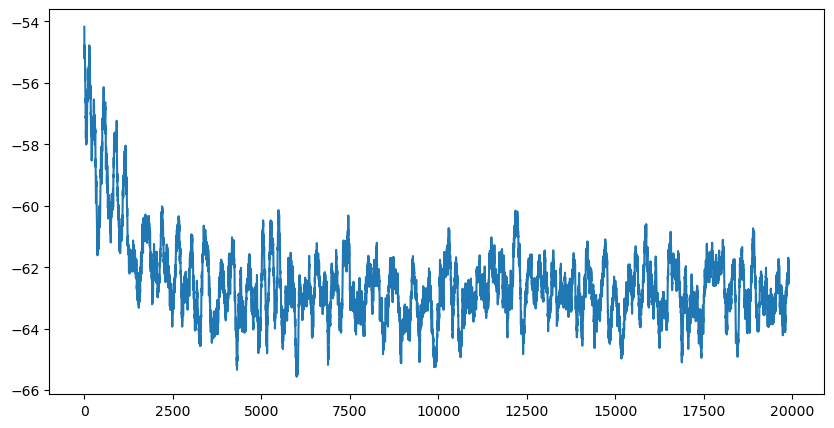

In [16]:
plt.rcParams['figure.figsize'] = [10, 5]
plt.plot(np.convolve(cumulative_discounted_rewards,np.ones(100)/100,mode='valid'))

In [17]:
def simulate_policy(q_fn):
    x0_odeint = get_random_initial_state()
    X_odeint = [x0_odeint]
    uvec = []

    state_c = x0_odeint
    state = discretizer.discretize_state(state_c)
    total_rewards = 0

    for step in range(max_steps):
        action = np.argmax([q_fn(state, 0), q_fn(state, 1)])

        # convert action into force
        if action == 1:
            F = 10
        else:
            F = -10
            
        uvec.append(F)

        # Simulate the system
        x_odeint = odeint(cart_and_pole_odeint, state_c, t_odeint, args=(F, ))
        new_state_c = x_odeint[1]
        new_state = discretizer.discretize_state(new_state_c)
        X_odeint=np.append(X_odeint, [state_c], axis= 0)

        if discretizer.is_terminal_state(new_state):
            reward = -10
        else:
            reward = 1

        total_rewards =total_rewards + reward

        # Our new state is state
        state = new_state
        state_c = new_state_c

        # If done (if we're dead) : finish episode
        if discretizer.is_terminal_state(new_state):
            break
    
    print("Time:", np.arange(0.0, 10, time_step)[:len(uvec)][-1])
    time_sim=np.arange(0.0, 10+time_step, time_step)

    plt.rcParams['figure.figsize'] = [10, 15]
    fig, axs = plt.subplots(5)
    fig.subplots_adjust(hspace=0.5)

    axs[0].plot(np.arange(0.0, 10, time_step)[:len(uvec)], uvec, 'r', label='U(t)')
    axs[0].set_title("U")

    axs[1].plot(time_sim[:X_odeint[:,0].shape[0]], X_odeint[:,0], 'b')
    axs[1].set_title("theta(t)")

    axs[2].plot(time_sim[:X_odeint[:,1].shape[0]], X_odeint[:,1], 'b')
    axs[2].set_title("dot theta(t)")

    axs[3].plot(time_sim[:X_odeint[:,2].shape[0]], X_odeint[:,2], 'b')
    axs[3].set_title("p_c(t)")

    axs[4].plot(time_sim[:X_odeint[:,3].shape[0]], X_odeint[:,3], 'b')
    axs[4].set_title("dot p_c(t)")

Time: 0.22


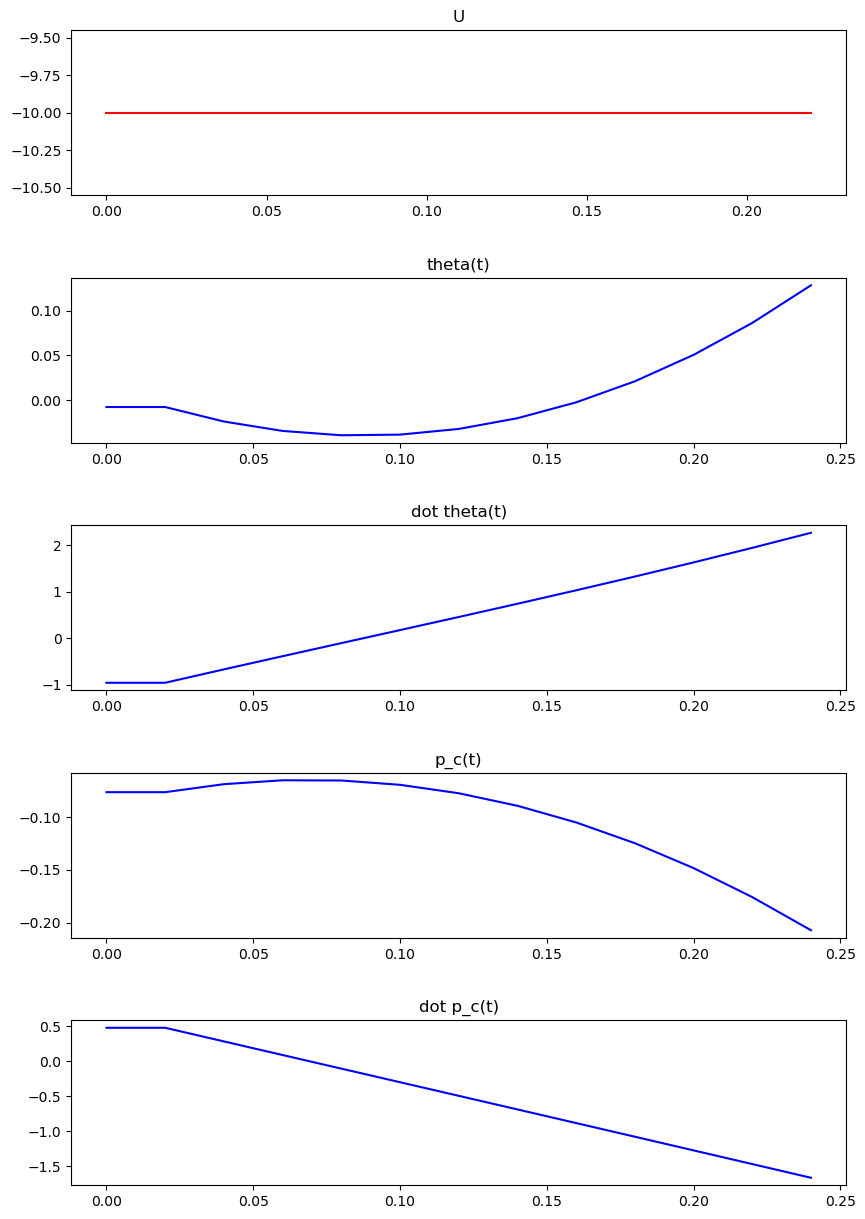

In [18]:
simulate_policy(qtable_func)

In [19]:
save_array(Weights, "Weights_5_qlearning.npy")

# 3. Copy and paste your Q-learning algorithm with function approximation and apply the changes needed to convert it into a SARSA algorithm with function approximation


In [20]:
Weights_sarsa = load_or_init_Weights("Weights_5_sarsa.npy", [rbf_means.shape[0], action_size])
Weights_sarsa.shape

(640, 2)

In [21]:
def q_function_sarsa(state, action):
    # discretized action, not the force!
    return Weights_sarsa[:, action] @ Phi(state)

q_function_sarsa(np.array([np.pi, 1, 2, 3]), 0), q_function_sarsa(np.array([np.pi, 1, 2, 3]), 1)

(-3.948638786408008e-21, -4.330863191858269e-21)

In [22]:
cumulative_discounted_rewards_sarsa = []
actions = []
epsilon_decay = 0

In [23]:
# List of rewards

for episode in tqdm(range(total_episodes)):
    # Reset the environment
    state_c = get_random_initial_state()
    
    state = discretizer.discretize_state(state_c)
    episode_reward = 0

    action = episilon_greedy_policy(epsilon, state_c, q_function_sarsa)
    
    for step in range(max_steps):
        actions.append(action)
        # convert action into force
        if action == 1:
            F = 10
        else:
            F = -10

        # Simulate the system
        x_odeint = odeint(cart_and_pole_odeint, state_c, t_odeint, args=(F, ))
        new_state_c = x_odeint[1]
        new_state = discretizer.discretize_state(new_state_c)

        new_action = episilon_greedy_policy(epsilon, new_state_c, q_function_sarsa)
        
        if discretizer.is_terminal_state(new_state):
            reward = -100
        else:
            reward = 1

        # Update Weights
        gradient = Phi(state_c)
        Weights_sarsa[:, action] = Weights_sarsa[:, action] + \
        learning_rate * ( (reward + gamma * q_function_sarsa(new_state_c, new_action) - q_function_sarsa(state_c, action)) * gradient)
                
        episode_reward += reward * gamma ** step
        
        # Our new state is state
        state = new_state
        state_c = new_state_c
        action = new_action
        
        # If done (if we're dead) : finish episode
        if discretizer.is_terminal_state(new_state):
            break
        
    # Reduce epsilon
    epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*epsilon_decay)
    epsilon_decay += 1 
    cumulative_discounted_rewards_sarsa.append(episode_reward)

    if episode % DEBUG_INFO_RATE == 0:
        print(np.average(cumulative_discounted_rewards_sarsa[-DEBUG_INFO_RATE:]), epsilon)
    


print ("Score over time: " +  str(sum(cumulative_discounted_rewards)/total_episodes))
print("Epsilon:", epsilon)

  0%|          | 7/20000 [00:00<05:16, 63.09it/s]

-55.6299291669531 1.0


  5%|▌         | 1022/20000 [00:08<02:25, 130.50it/s]

-46.95140569816911 0.3742006467597279


 10%|█         | 2013/20000 [00:15<02:31, 118.67it/s]

-53.91663629388178 0.1439819304042466


 15%|█▌        | 3040/20000 [00:21<01:25, 199.45it/s]

-58.1740935909517 0.05928919768418531


 20%|██        | 4033/20000 [00:27<01:28, 179.87it/s]

-60.75501265493303 0.028132482499846838


 25%|██▌       | 5022/20000 [00:33<01:27, 171.73it/s]

-62.51024273914423 0.016670567529094613


 30%|███       | 6020/20000 [00:39<01:20, 173.56it/s]

-61.777134879422405 0.012453964654899695


 35%|███▌      | 7035/20000 [00:44<01:13, 175.74it/s]

-62.04020124633882 0.010902763145898971


 40%|████      | 8025/20000 [00:50<01:13, 162.16it/s]

-63.412897525277245 0.010332108001623487


 45%|████▌     | 9021/20000 [00:56<01:06, 164.51it/s]

-63.07795746793809 0.010122175706045813


 50%|█████     | 10027/20000 [01:01<00:49, 201.23it/s]

-64.8802424860188 0.010044945930464861


 55%|█████▌    | 11027/20000 [01:07<00:48, 184.50it/s]

-63.497838603010344 0.010016534683782344


 60%|██████    | 12039/20000 [01:13<00:41, 192.47it/s]

-63.70013873695521 0.010006082770229794


 65%|██████▌   | 13023/20000 [01:19<00:42, 164.64it/s]

-62.834109214951496 0.010002237726112912


 70%|███████   | 14034/20000 [01:24<00:32, 185.79it/s]

-64.19323803340241 0.010000823213431913


 75%|███████▌  | 15033/20000 [01:30<00:28, 171.58it/s]

-63.03933619667003 0.010000302843297297


 80%|████████  | 16040/20000 [01:35<00:17, 222.66it/s]

-63.26130506127077 0.010000111409822971


 85%|████████▌ | 17029/20000 [01:40<00:13, 214.59it/s]

-63.22831295778851 0.010000040985383415


 90%|█████████ | 18033/20000 [01:44<00:09, 197.71it/s]

-63.65020734489476 0.010000015077679947


 95%|█████████▌| 19021/20000 [01:49<00:04, 207.23it/s]

-63.30601522520892 0.010000005546768474


100%|██████████| 20000/20000 [01:54<00:00, 174.92it/s]

Score over time: -62.47662208390465
Epsilon: 0.01000000204258365


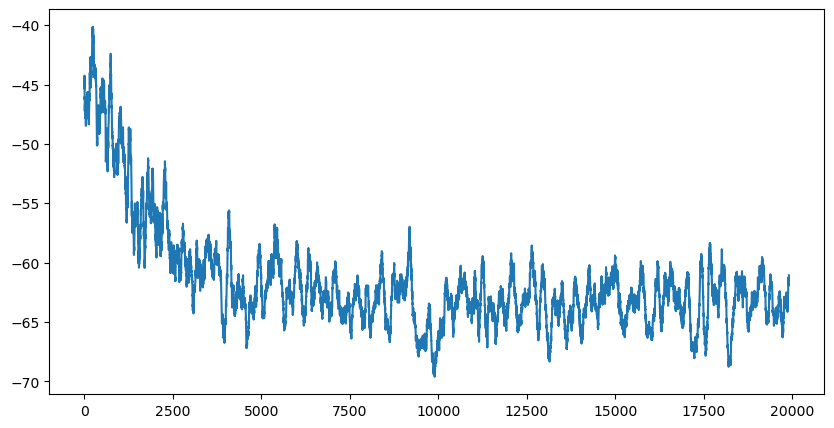

In [24]:
plt.rcParams['figure.figsize'] = [10, 5]
plt.plot(np.convolve(cumulative_discounted_rewards_sarsa,np.ones(100)/100,mode='valid'))

Time: 0.18


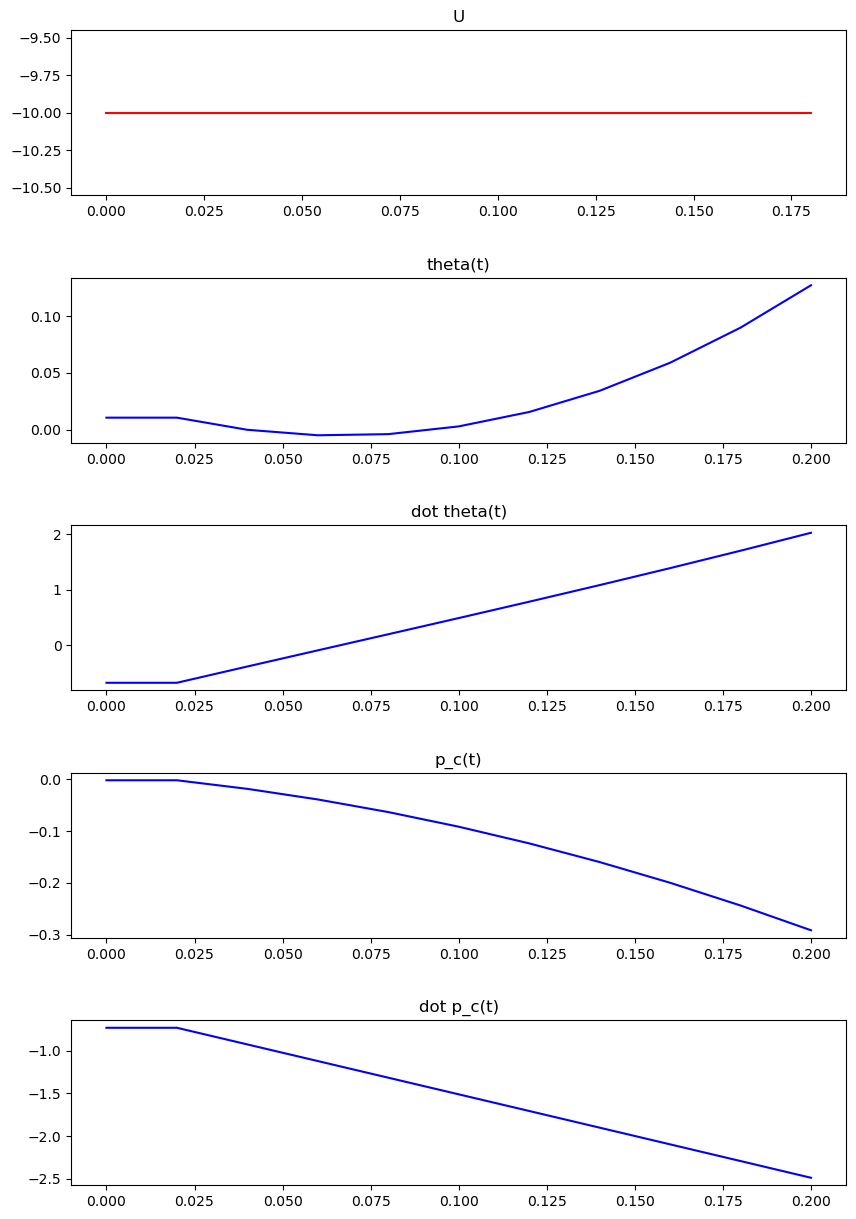

In [25]:
simulate_policy(q_function_sarsa)

In [26]:
save_array(Weights_sarsa, "Weights_5_sarsa.npy")